In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(128, activation='relu'))
        
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 105.6640 - mae: 2.9029 - mape: 190.6278 - student_loss: 2.8964 - distillation_loss: 104.7399 - val_mse: 1.0614 - val_mae: 0.8126 - val_mape: 63.1499 - val_student_loss: 0.9246
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1262 - mae: 0.7885 - mape: 54.4012 - student_loss: 0.7883 - distillation_loss: 0.6910 - val_mse: 0.9001 - val_mae: 0.7222 - val_mape: 57.4176 - val_student_loss: 0.8780
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0213 - mae: 0.7512 - mape: 50.7762 - student_loss: 0.7491 - distillation_loss: 0.5936 - val_mse: 0.7405 - val_mae: 0.6116 - val_mape: 40.4703 - val_student_loss: 0.7957
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 18.9824 - mae: 1.9073 - mape: 124.8897 - student_loss: 1.9031 - distillation_loss: 18.5096 - val_mse: 1.5995 - val_mae: 0.9322 - val_mape: 75.2153 - val_student_loss: 0.8792
Epoch

443/443 [==============================] - 1s 2ms/step - mse: 0.6610 - mae: 0.6064 - mape: 39.5835 - student_loss: 0.6059 - distillation_loss: 0.2422 - val_mse: 0.6347 - val_mae: 0.6441 - val_mape: 47.7306 - val_student_loss: 0.7744
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5384 - mae: 0.5563 - mape: 36.1114 - student_loss: 0.5560 - distillation_loss: 0.1137 - val_mse: 0.5906 - val_mae: 0.6194 - val_mape: 45.0828 - val_student_loss: 0.7505
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6732 - mae: 0.6170 - mape: 39.9415 - student_loss: 0.6184 - distillation_loss: 0.2545 - val_mse: 0.7400 - val_mae: 0.6265 - val_mape: 33.8437 - val_student_loss: 0.7645
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6933 - mae: 0.6178 - mape: 40.6359 - student_loss: 0.6182 - distillation_loss: 0.2685 - val_mse: 0.5535 - val_mae: 0.5882 - val_mape: 42.4804 - val_student_loss: 0.6610
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4435 - mae: 0.5032 - mape: 32.1133 - student_loss: 0.5033 - distillation_loss: 0.0432 - val_mse: 0.4102 - val_mae: 0.4809 - val_mape: 30.1905 - val_student_loss: 0.6101
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4496 - mae: 0.5065 - mape: 32.1828 - student_loss: 0.5070 - distillation_loss: 0.0490 - val_mse: 0.4198 - val_mae: 0.4886 - val_mape: 31.4525 - val_student_loss: 0.6201
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4488 - mae: 0.5045 - mape: 32.1346 - student_loss: 0.5043 - distillation_loss: 0.0501 - val_mse: 0.4063 - val_mae: 0.4814 - val_mape: 30.5152 - val_student_loss: 0.6312
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4436 - mae: 0.5021 - mape: 31.9334 - student_loss: 0.5031 - distillation_loss: 0.0434 - val_mse: 0.4082 - val_mae: 0.4835 - val_mape: 31.1266 - val_student_loss: 0.6276
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4299 - mae: 0.4969 - mape: 32.4808 - student_loss: 0.4971 - distillation_loss: 0.0376 - val_mse: 0.3891 - val_mae: 0.4767 - val_mape: 31.5664 - val_student_loss: 0.6079
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 5.3089 - mse: 517.3099 - mae: 5.3089 - mape: 345.8404 - val_loss: 0.6824 - val_mse: 0.9125 - val_mae: 0.6824 - val_mape: 45.3444
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 2.3730 - mse: 13.8471 - mae: 2.3730 - mape: 157.1992 - val_loss: 1.8809 - val_mse: 5.6342 - val_mae: 1.8809 - val_mape: 109.5320
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 2.2734 - mse: 12.6793 - mae: 2.2734 - mape: 151.0686 - val_loss: 1.5978 - val_mse: 4.3014 - val_mae: 1.5978 - val_mape: 123.1177
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 3.3927 - mse: 30.4490 - mae: 3.3927 - mape: 224.1098 - val_loss: 0.6285 - val_ms

443/443 [==============================] - 1s 2ms/step - loss: 0.5600 - mse: 0.6672 - mae: 0.5600 - mape: 34.2209 - val_loss: 0.5309 - val_mse: 0.5460 - val_mae: 0.5309 - val_mape: 29.6773
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5736 - mse: 0.6319 - mae: 0.5736 - mape: 34.9640 - val_loss: 0.5580 - val_mse: 0.7620 - val_mae: 0.5580 - val_mape: 30.1659
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5739 - mse: 0.6715 - mae: 0.5739 - mape: 35.3330 - val_loss: 0.5346 - val_mse: 0.5285 - val_mae: 0.5346 - val_mape: 36.3848
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5545 - mse: 0.5764 - mae: 0.5545 - mape: 33.8994 - val_loss: 0.5656 - val_mse: 0.6939 - val_mae: 0.5656 - val_mape: 30.3842
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5563 - mse: 0.5686 - mae: 0.5563 - mape: 33.9394 - val_loss: 0.7087 - val_mse: 0.8543 - val_mae: 0.7087 - val_mape: 53.1319
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4820 - mse: 0.4265 - mae: 0.4820 - mape: 29.0515 - val_loss: 0.4987 - val_mse: 0.4527 - val_mae: 0.4987 - val_mape: 28.3488
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4849 - mse: 0.4288 - mae: 0.4849 - mape: 29.4420 - val_loss: 0.4612 - val_mse: 0.3935 - val_mae: 0.4612 - val_mape: 27.4478
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4891 - mse: 0.4353 - mae: 0.4891 - mape: 29.6277 - val_loss: 0.5041 - val_mse: 0.4742 - val_mae: 0.5041 - val_mape: 27.1423
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4842 - mse: 0.4289 - mae: 0.4842 - mape: 29.1751 - val_loss: 0.4629 - val_mse: 0.3871 - val_mae: 0.4629 - val_mape: 27.8234
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4818 - mse: 0.4256 - mae: 0.4818 - mape: 29.0544 - val_loss: 0.4967 - val_mse: 0.4042 - val_mae: 0.4967 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 95.1536 - mae: 3.2194 - mape: 211.5712 - student_loss: 3.2096 - distillation_loss: 94.3377 - val_mse: 0.6215 - val_mae: 0.6219 - val_mape: 44.3918 - val_student_loss: 0.6661
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6975 - mae: 0.6092 - mape: 41.0661 - student_loss: 0.6093 - distillation_loss: 0.2736 - val_mse: 0.5572 - val_mae: 0.5742 - val_mape: 37.7455 - val_student_loss: 0.4812
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6657 - mae: 0.6123 - mape: 40.9051 - student_loss: 0.6110 - distillation_loss: 0.2334 - val_mse: 0.5496 - val_mae: 0.5639 - val_mape: 35.3884 - val_student_loss: 0.4495
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0626 - mae: 0.7073 - mape: 47.0808 - student_loss: 0.7077 - distillation_loss: 0.6295 - val_mse: 1.9246 - val_mae: 1.0150 - val_mape: 76.0289 - val_student_loss: 1.0532
Epoch 22/100


443/443 [==============================] - 1s 2ms/step - mse: 0.4996 - mae: 0.5354 - mape: 34.5539 - student_loss: 0.5366 - distillation_loss: 0.0883 - val_mse: 0.8349 - val_mae: 0.7573 - val_mape: 56.7876 - val_student_loss: 0.8244
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6604 - mae: 0.5913 - mape: 38.4974 - student_loss: 0.5917 - distillation_loss: 0.2433 - val_mse: 0.4757 - val_mae: 0.5302 - val_mape: 34.1172 - val_student_loss: 0.3580
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6324 - mae: 0.5970 - mape: 38.8431 - student_loss: 0.5980 - distillation_loss: 0.2116 - val_mse: 0.4797 - val_mae: 0.5377 - val_mape: 35.7527 - val_student_loss: 0.3842
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5117 - mae: 0.5407 - mape: 34.7185 - student_loss: 0.5407 - distillation_loss: 0.1005 - val_mse: 0.4883 - val_mae: 0.5227 - val_mape: 30.8284 - val_student_loss: 0.2893
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4532 - mae: 0.5071 - mape: 32.6730 - student_loss: 0.5065 - distillation_loss: 0.0459 - val_mse: 0.4472 - val_mae: 0.4946 - val_mape: 28.9671 - val_student_loss: 0.1754
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4418 - mae: 0.5012 - mape: 32.2009 - student_loss: 0.5038 - distillation_loss: 0.0437 - val_mse: 0.4226 - val_mae: 0.5023 - val_mape: 33.1798 - val_student_loss: 0.3393
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4909 - mae: 0.5226 - mape: 33.8677 - student_loss: 0.5228 - distillation_loss: 0.0865 - val_mse: 0.4317 - val_mae: 0.4906 - val_mape: 29.5646 - val_student_loss: 0.2245
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4450 - mae: 0.5014 - mape: 32.4181 - student_loss: 0.5006 - distillation_loss: 0.0460 - val_mse: 0.4184 - val_mae: 0.4875 - val_mape: 30.4033 - val_student_loss: 0.2861
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7799 - mse: 1.2974 - mae: 0.7799 - mape: 49.6587 - val_loss: 1.0351 - val_mse: 1.8632 - val_mae: 1.0351 - val_mape: 76.4791
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7852 - mse: 1.1675 - mae: 0.7852 - mape: 50.4150 - val_loss: 0.6677 - val_mse: 0.7443 - val_mae: 0.6677 - val_mape: 48.3292
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7517 - mse: 1.0963 - mae: 0.7517 - mape: 47.7579 - val_loss: 0.5282 - val_mse: 0.5171 - val_mae: 0.5282 - val_mape: 29.5617
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7626 - mse: 1.1379 - mae: 0.7626 - mape: 48.9342 - val_loss: 0.8218 - val_mse: 1.1439 - val_mae: 0.8218 - val_mape: 60.6041
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7397 - mse: 1.0194 - mae: 0.7397 - mape: 47.2013 - val_loss: 0.8857 - val_mse: 1.7743 - val_mae: 0.8857 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5110 - mse: 0.4690 - mae: 0.5110 - mape: 31.5552 - val_loss: 0.5220 - val_mse: 0.5105 - val_mae: 0.5220 - val_mape: 28.2929
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5091 - mse: 0.4719 - mae: 0.5091 - mape: 31.1743 - val_loss: 0.5344 - val_mse: 0.4503 - val_mae: 0.5344 - val_mape: 38.1583
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5155 - mse: 0.4766 - mae: 0.5155 - mape: 31.8734 - val_loss: 0.5219 - val_mse: 0.5062 - val_mae: 0.5219 - val_mape: 28.5383
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5066 - mse: 0.4684 - mae: 0.5066 - mape: 31.0378 - val_loss: 0.4848 - val_mse: 0.4246 - val_mae: 0.4848 - val_mape: 29.4325
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5053 - mse: 0.4638 - mae: 0.5053 - mape: 30.9507 - val_loss: 0.4942 - val_mse: 0.4461 - val_mae: 0.4942 - val_mape: 28.7845
Epo

443/443 [==============================] - 1s 2ms/step - mse: 91.0269 - mae: 2.5828 - mape: 173.1073 - student_loss: 2.5746 - distillation_loss: 90.1047 - val_mse: 0.7193 - val_mae: 0.6715 - val_mape: 50.0544 - val_student_loss: 0.5867
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7954 - mae: 0.6681 - mape: 44.0875 - student_loss: 0.6676 - distillation_loss: 0.3717 - val_mse: 0.6228 - val_mae: 0.5793 - val_mape: 34.3814 - val_student_loss: 0.5437
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1476 - mae: 1.2688 - mape: 83.8429 - student_loss: 1.2666 - distillation_loss: 3.7137 - val_mse: 11.0624 - val_mae: 2.5851 - val_mape: 156.3744 - val_student_loss: 1.9329
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 460.0248 - mae: 5.9144 - mape: 390.8294 - student_loss: 5.8925 - distillation_loss: 457.7294 - val_mse: 0.6564 - val_mae: 0.6447 - val_mape: 47.7309 - val_student_loss: 0.5293
Epoch 5/100
443/443 [=

443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.6760 - mape: 44.7349 - student_loss: 0.6763 - distillation_loss: 0.5237 - val_mse: 0.5313 - val_mae: 0.5691 - val_mape: 39.7827 - val_student_loss: 0.4888
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1327 - mae: 0.6710 - mape: 44.2097 - student_loss: 0.6708 - distillation_loss: 0.7019 - val_mse: 0.5262 - val_mae: 0.5383 - val_mape: 33.8952 - val_student_loss: 0.4843
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5661 - mae: 0.5728 - mape: 37.7950 - student_loss: 0.5723 - distillation_loss: 0.1423 - val_mse: 0.5177 - val_mae: 0.5312 - val_mape: 33.2250 - val_student_loss: 0.5010
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5263 - mae: 0.5546 - mape: 36.2375 - student_loss: 0.5550 - distillation_loss: 0.1056 - val_mse: 0.5097 - val_mae: 0.5287 - val_mape: 33.0525 - val_student_loss: 0.5193
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4405 - mae: 0.5016 - mape: 32.3081 - student_loss: 0.5010 - distillation_loss: 0.0401 - val_mse: 0.4488 - val_mae: 0.4869 - val_mape: 28.8580 - val_student_loss: 0.4793
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4413 - mae: 0.5009 - mape: 32.1497 - student_loss: 0.5012 - distillation_loss: 0.0419 - val_mse: 0.4244 - val_mae: 0.4890 - val_mape: 31.5060 - val_student_loss: 0.4968
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4444 - mae: 0.5024 - mape: 32.2874 - student_loss: 0.5023 - distillation_loss: 0.0453 - val_mse: 0.4207 - val_mae: 0.4845 - val_mape: 31.1251 - val_student_loss: 0.4753
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4355 - mae: 0.4975 - mape: 31.9611 - student_loss: 0.4971 - distillation_loss: 0.0358 - val_mse: 0.4748 - val_mae: 0.5386 - val_mape: 36.9929 - val_student_loss: 0.4866
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4569 - mae: 0.5134 - mape: 33.1418 - student_loss: 0.5137 - distillation_loss: 0.0600 - val_mse: 0.4384 - val_mae: 0.4857 - val_mape: 30.1970 - val_student_loss: 0.4724
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 5.5486 - mse: 83.5703 - mae: 5.5486 - mape: 369.8423 - val_loss: 4.9759 - val_mse: 45.9424 - val_mae: 4.9759 - val_mape: 362.4935
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 4.1349 - mse: 41.3970 - mae: 4.1349 - mape: 274.9664 - val_loss: 9.9737 - val_mse: 146.9994 - val_mae: 9.9737 - val_mape: 653.0698
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 4.6957 - mse: 57.9196 - mae: 4.6957 - mape: 317.0350 - val_loss: 3.6679 - val_mse: 20.4631 - val_mae: 3.6679 - val_mape: 227.5013
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 4.6491 - mse: 52.4692 - mae: 4.6491 - mape: 308.3874 - val_loss: 1.6841 - va

443/443 [==============================] - 1s 2ms/step - loss: 0.7150 - mse: 1.0062 - mae: 0.7150 - mape: 45.7396 - val_loss: 0.5905 - val_mse: 0.5778 - val_mae: 0.5905 - val_mape: 40.8088
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7275 - mse: 1.1220 - mae: 0.7275 - mape: 45.9605 - val_loss: 0.6604 - val_mse: 0.8119 - val_mae: 0.6604 - val_mape: 35.4301
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6940 - mse: 0.9295 - mae: 0.6940 - mape: 44.1146 - val_loss: 0.5306 - val_mse: 0.4860 - val_mae: 0.5306 - val_mape: 34.7575
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6447 - mse: 0.8587 - mae: 0.6447 - mape: 40.5645 - val_loss: 0.5155 - val_mse: 0.4688 - val_mae: 0.5155 - val_mape: 33.3483
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6855 - mse: 1.0531 - mae: 0.6855 - mape: 43.3015 - val_loss: 1.3440 - val_mse: 3.0330 - val_mae: 1.3440 - val_mape: 101.0278
Ep

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5016 - mse: 0.4517 - mae: 0.5016 - mape: 30.8435 - val_loss: 0.4899 - val_mse: 0.4688 - val_mae: 0.4899 - val_mape: 27.0205
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5009 - mse: 0.4537 - mae: 0.5009 - mape: 30.8383 - val_loss: 0.4881 - val_mse: 0.4159 - val_mae: 0.4881 - val_mape: 31.1230
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4957 - mse: 0.4440 - mae: 0.4957 - mape: 30.4092 - val_loss: 0.4702 - val_mse: 0.4216 - val_mae: 0.4702 - val_mape: 28.6021
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5024 - mse: 0.4570 - mae: 0.5024 - mape: 30.7177 - val_loss: 0.5348 - val_mse: 0.5487 - val_mae: 0.5348 - val_mape: 28.4689
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4926 - mse: 0.4403 - mae: 0.4926 - mape: 30.1828 - val_loss: 0.5610 - val_mse: 0.5013 - val_mae: 0.5610 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 2.3921 - mae: 0.8828 - mape: 58.4524 - student_loss: 0.8814 - distillation_loss: 1.9736 - val_mse: 0.5271 - val_mae: 0.5714 - val_mape: 41.0188 - val_student_loss: 0.3687
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1528 - mae: 0.7455 - mape: 48.7242 - student_loss: 0.7467 - distillation_loss: 0.7392 - val_mse: 0.5621 - val_mae: 0.5438 - val_mape: 32.1694 - val_student_loss: 0.2486
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6590 - mae: 0.5995 - mape: 38.6482 - student_loss: 0.6012 - distillation_loss: 0.2488 - val_mse: 2.7388 - val_mae: 1.2373 - val_mape: 70.3427 - val_student_loss: 0.6684
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2417 - mae: 0.7408 - mape: 48.2280 - student_loss: 0.7470 - distillation_loss: 0.8396 - val_mse: 9.1004 - val_mae: 2.3996 - val_mape: 147.5550 - val_student_loss: 1.3832
Epoch 22/100
44

443/443 [==============================] - 1s 2ms/step - mse: 0.5212 - mae: 0.5386 - mape: 34.8113 - student_loss: 0.5380 - distillation_loss: 0.1109 - val_mse: 0.4909 - val_mae: 0.5469 - val_mape: 38.2345 - val_student_loss: 0.3667
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4922 - mae: 0.5281 - mape: 34.2969 - student_loss: 0.5277 - distillation_loss: 0.0871 - val_mse: 0.4549 - val_mae: 0.5097 - val_mape: 34.2277 - val_student_loss: 0.3104
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5533 - mae: 0.5531 - mape: 36.0218 - student_loss: 0.5519 - distillation_loss: 0.1449 - val_mse: 0.4576 - val_mae: 0.5200 - val_mape: 36.3192 - val_student_loss: 0.3469
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6336 - mae: 0.5676 - mape: 36.8348 - student_loss: 0.5674 - distillation_loss: 0.2256 - val_mse: 0.4926 - val_mae: 0.5499 - val_mape: 39.0387 - val_student_loss: 0.4351
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4282 - mae: 0.4917 - mape: 31.7648 - student_loss: 0.4917 - distillation_loss: 0.0362 - val_mse: 0.4254 - val_mae: 0.4863 - val_mape: 32.8618 - val_student_loss: 0.2970
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4257 - mae: 0.4908 - mape: 31.7376 - student_loss: 0.4905 - distillation_loss: 0.0340 - val_mse: 0.4562 - val_mae: 0.5280 - val_mape: 38.5763 - val_student_loss: 0.4235
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4183 - mae: 0.4873 - mape: 31.6214 - student_loss: 0.4863 - distillation_loss: 0.0281 - val_mse: 0.4290 - val_mae: 0.4963 - val_mape: 34.2419 - val_student_loss: 0.3330
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4080 - mae: 0.4799 - mape: 31.0241 - student_loss: 0.4805 - distillation_loss: 0.0189 - val_mse: 0.5565 - val_mae: 0.5929 - val_mape: 43.4891 - val_student_loss: 0.4796
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7789 - mse: 1.2313 - mae: 0.7789 - mape: 49.8830 - val_loss: 0.9776 - val_mse: 1.5737 - val_mae: 0.9776 - val_mape: 75.1023
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8859 - mse: 1.6261 - mae: 0.8859 - mape: 56.3185 - val_loss: 0.5865 - val_mse: 0.6634 - val_mae: 0.5865 - val_mape: 41.7910
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7896 - mse: 1.2173 - mae: 0.7896 - mape: 50.5649 - val_loss: 0.8191 - val_mse: 1.1520 - val_mae: 0.8191 - val_mape: 43.8291
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8047 - mse: 1.2815 - mae: 0.8047 - mape: 51.2715 - val_loss: 0.6518 - val_mse: 0.8387 - val_mae: 0.6518 - val_mape: 34.8565
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7655 - mse: 1.3125 - mae: 0.7655 - mape: 48.6538 - val_loss: 0.5331 - val_mse: 0.5583 - val_mae: 0.5331 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5042 - mse: 0.4715 - mae: 0.5042 - mape: 30.5701 - val_loss: 0.5251 - val_mse: 0.4694 - val_mae: 0.5251 - val_mape: 37.0110
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5121 - mse: 0.4784 - mae: 0.5121 - mape: 31.1429 - val_loss: 0.5595 - val_mse: 0.5151 - val_mae: 0.5595 - val_mape: 39.6772
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5066 - mse: 0.4664 - mae: 0.5066 - mape: 30.7065 - val_loss: 0.6006 - val_mse: 0.5776 - val_mae: 0.6006 - val_mape: 44.8957
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5143 - mse: 0.4769 - mae: 0.5143 - mape: 31.3122 - val_loss: 0.5295 - val_mse: 0.5401 - val_mae: 0.5295 - val_mape: 29.6703
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5028 - mse: 0.4594 - mae: 0.5028 - mape: 30.5029 - val_loss: 0.5045 - val_mse: 0.4469 - val_mae: 0.5045 - val_mape: 34.9727
Epo

443/443 [==============================] - 1s 3ms/step - mse: 254.6051 - mae: 3.8688 - mape: 257.2452 - student_loss: 3.8559 - distillation_loss: 253.1505 - val_mse: 0.8280 - val_mae: 0.7071 - val_mape: 45.7157 - val_student_loss: 0.4892
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 8.7686 - mae: 1.3148 - mape: 90.1384 - student_loss: 1.3135 - distillation_loss: 8.3054 - val_mse: 0.9546 - val_mae: 0.8003 - val_mape: 62.0509 - val_student_loss: 0.3673
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 118.1232 - mae: 3.3260 - mape: 221.0782 - student_loss: 3.3170 - distillation_loss: 117.2118 - val_mse: 5.8140 - val_mae: 1.8200 - val_mape: 137.7687 - val_student_loss: 1.0923
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.1826 - mae: 1.0200 - mape: 67.3795 - student_loss: 1.0184 - distillation_loss: 1.7481 - val_mse: 0.9248 - val_mae: 0.7749 - val_mape: 57.4208 - val_student_loss: 0.5598
Epoch 5/100
443/443 [

443/443 [==============================] - 1s 2ms/step - mse: 2.4406 - mae: 0.9096 - mape: 59.6445 - student_loss: 0.9097 - distillation_loss: 2.0262 - val_mse: 0.5199 - val_mae: 0.5376 - val_mape: 32.7991 - val_student_loss: 0.5284
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 2.0444 - mae: 0.8715 - mape: 56.9560 - student_loss: 0.8705 - distillation_loss: 1.6483 - val_mse: 0.4921 - val_mae: 0.5476 - val_mape: 37.2626 - val_student_loss: 0.4713
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 2.9549 - mae: 1.0091 - mape: 66.4296 - student_loss: 1.0074 - distillation_loss: 2.5194 - val_mse: 0.6693 - val_mae: 0.6646 - val_mape: 48.4292 - val_student_loss: 0.4424
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1130 - mae: 0.7260 - mape: 46.9615 - student_loss: 0.7240 - distillation_loss: 0.7097 - val_mse: 2.1647 - val_mae: 1.1103 - val_mape: 60.7992 - val_student_loss: 0.7684
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6936 - mae: 0.6166 - mape: 40.0033 - student_loss: 0.6167 - distillation_loss: 0.2810 - val_mse: 0.5712 - val_mae: 0.6085 - val_mape: 43.0529 - val_student_loss: 0.4520
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7801 - mae: 0.6409 - mape: 41.6293 - student_loss: 0.6398 - distillation_loss: 0.3619 - val_mse: 0.5072 - val_mae: 0.5417 - val_mape: 35.1539 - val_student_loss: 0.4793
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5149 - mae: 0.5480 - mape: 35.7449 - student_loss: 0.5473 - distillation_loss: 0.0941 - val_mse: 0.5277 - val_mae: 0.5389 - val_mape: 31.5372 - val_student_loss: 0.5259
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5260 - mae: 0.5520 - mape: 35.8080 - student_loss: 0.5521 - distillation_loss: 0.1089 - val_mse: 0.4863 - val_mae: 0.5292 - val_mape: 33.7312 - val_student_loss: 0.4904
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4509 - mae: 0.5080 - mape: 33.0160 - student_loss: 0.5086 - distillation_loss: 0.0481 - val_mse: 0.4365 - val_mae: 0.4908 - val_mape: 29.8172 - val_student_loss: 0.4820
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.7912 - mse: 722.6948 - mae: 7.7912 - mape: 533.6372 - val_loss: 1.4543 - val_mse: 3.2935 - val_mae: 1.4543 - val_mape: 112.4411
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 4.8142 - mse: 60.8732 - mae: 4.8142 - mape: 320.1009 - val_loss: 6.1545 - val_mse: 57.8709 - val_mae: 6.1545 - val_mape: 429.9416
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 4.5116 - mse: 50.8521 - mae: 4.5116 - mape: 300.9534 - val_loss: 6.5388 - val_mse: 65.4179 - val_mae: 6.5388 - val_mape: 414.6747
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 3.3132 - mse: 28.9833 - mae: 3.3132 - mape: 217.9737 - val_loss: 1.1972 - val

443/443 [==============================] - 1s 2ms/step - loss: 0.8458 - mse: 1.5905 - mae: 0.8458 - mape: 54.3266 - val_loss: 1.1862 - val_mse: 2.3622 - val_mae: 1.1862 - val_mape: 66.2785
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7559 - mse: 1.1385 - mae: 0.7559 - mape: 47.8100 - val_loss: 1.1978 - val_mse: 2.3040 - val_mae: 1.1978 - val_mape: 88.5784
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7430 - mse: 1.1374 - mae: 0.7430 - mape: 47.7025 - val_loss: 0.8305 - val_mse: 1.1378 - val_mae: 0.8305 - val_mape: 59.4469
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7157 - mse: 1.0994 - mae: 0.7157 - mape: 45.2265 - val_loss: 0.8964 - val_mse: 1.2951 - val_mae: 0.8964 - val_mape: 47.5047
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8362 - mse: 1.5004 - mae: 0.8362 - mape: 53.2511 - val_loss: 0.5107 - val_mse: 0.4586 - val_mae: 0.5107 - val_mape: 32.3052
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5132 - mse: 0.4813 - mae: 0.5132 - mape: 31.4804 - val_loss: 0.4832 - val_mse: 0.4357 - val_mae: 0.4832 - val_mape: 28.3164
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5225 - mse: 0.4950 - mae: 0.5225 - mape: 32.2259 - val_loss: 0.5134 - val_mse: 0.4945 - val_mae: 0.5134 - val_mape: 27.2675
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5071 - mse: 0.4714 - mae: 0.5071 - mape: 31.0632 - val_loss: 0.7536 - val_mse: 0.9075 - val_mae: 0.7536 - val_mape: 54.0600
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5216 - mse: 0.4915 - mae: 0.5216 - mape: 32.1732 - val_loss: 0.6222 - val_mse: 0.6840 - val_mae: 0.6222 - val_mape: 31.3885
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5164 - mse: 0.4919 - mae: 0.5164 - mape: 31.9497 - val_loss: 0.4854 - val_mse: 0.4435 - val_mae: 0.4854 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5678 - mae: 0.5779 - mape: 37.9809 - student_loss: 0.5780 - distillation_loss: 0.1484 - val_mse: 0.5268 - val_mae: 0.5264 - val_mape: 32.7751 - val_student_loss: 0.7128
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7429 - mae: 0.6455 - mape: 41.8852 - student_loss: 0.6461 - distillation_loss: 0.3270 - val_mse: 1.3631 - val_mae: 0.9032 - val_mape: 47.0417 - val_student_loss: 1.4550
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 2.6132 - mae: 0.9243 - mape: 60.8239 - student_loss: 0.9239 - distillation_loss: 2.1593 - val_mse: 2.3067 - val_mae: 1.0812 - val_mape: 78.8362 - val_student_loss: 1.1695
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 21.3943 - mae: 1.5042 - mape: 103.1814 - student_loss: 1.5000 - distillation_loss: 20.8346 - val_mse: 0.6601 - val_mae: 0.5745 - val_mape: 38.9287 - val_student_loss: 0.6838
Epoch 22/100


443/443 [==============================] - 1s 2ms/step - mse: 0.6810 - mae: 0.6023 - mape: 39.9679 - student_loss: 0.6032 - distillation_loss: 0.2577 - val_mse: 0.5072 - val_mae: 0.5293 - val_mape: 36.0853 - val_student_loss: 0.7075
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4726 - mae: 0.5209 - mape: 33.8985 - student_loss: 0.5210 - distillation_loss: 0.0593 - val_mse: 0.4607 - val_mae: 0.5164 - val_mape: 34.5518 - val_student_loss: 0.6899
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4550 - mae: 0.5102 - mape: 32.8861 - student_loss: 0.5106 - distillation_loss: 0.0502 - val_mse: 0.4623 - val_mae: 0.5080 - val_mape: 33.5129 - val_student_loss: 0.6785
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5419 - mae: 0.5537 - mape: 36.1165 - student_loss: 0.5528 - distillation_loss: 0.1337 - val_mse: 0.4587 - val_mae: 0.5249 - val_mape: 35.9505 - val_student_loss: 0.7127
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4126 - mae: 0.4836 - mape: 31.2839 - student_loss: 0.4824 - distillation_loss: 0.0231 - val_mse: 0.4103 - val_mae: 0.4778 - val_mape: 31.4719 - val_student_loss: 0.6102
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4174 - mae: 0.4865 - mape: 31.4709 - student_loss: 0.4870 - distillation_loss: 0.0267 - val_mse: 0.4079 - val_mae: 0.4743 - val_mape: 30.8094 - val_student_loss: 0.6005
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4066 - mae: 0.4789 - mape: 30.9202 - student_loss: 0.4783 - distillation_loss: 0.0180 - val_mse: 0.4643 - val_mae: 0.4984 - val_mape: 28.6621 - val_student_loss: 0.6955
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4929 - mae: 0.5236 - mape: 33.9483 - student_loss: 0.5233 - distillation_loss: 0.0988 - val_mse: 0.4152 - val_mae: 0.4744 - val_mape: 29.5916 - val_student_loss: 0.6123
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8089 - mse: 1.3212 - mae: 0.8089 - mape: 51.8380 - val_loss: 0.7860 - val_mse: 1.1192 - val_mae: 0.7860 - val_mape: 41.6559
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7123 - mse: 0.9641 - mae: 0.7123 - mape: 44.8879 - val_loss: 0.5186 - val_mse: 0.6343 - val_mae: 0.5186 - val_mape: 30.4712
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7055 - mse: 0.9702 - mae: 0.7055 - mape: 44.9460 - val_loss: 0.6310 - val_mse: 0.9001 - val_mae: 0.6310 - val_mape: 34.9394
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7122 - mse: 1.0170 - mae: 0.7122 - mape: 44.9453 - val_loss: 0.7646 - val_mse: 1.0962 - val_mae: 0.7646 - val_mape: 39.3877
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6826 - mse: 0.8558 - mae: 0.6826 - mape: 43.0527 - val_loss: 0.9441 - val_mse: 1.4942 - val_mae: 0.9441 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.4941 - mse: 0.4510 - mae: 0.4941 - mape: 29.9262 - val_loss: 0.5016 - val_mse: 0.4845 - val_mae: 0.5016 - val_mape: 27.8559
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4989 - mse: 0.4526 - mae: 0.4989 - mape: 30.3773 - val_loss: 0.5482 - val_mse: 0.4851 - val_mae: 0.5482 - val_mape: 38.9781
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5071 - mse: 0.4689 - mae: 0.5071 - mape: 30.8068 - val_loss: 0.5015 - val_mse: 0.4326 - val_mae: 0.5015 - val_mape: 33.0175
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5102 - mse: 0.4715 - mae: 0.5102 - mape: 31.1069 - val_loss: 0.4947 - val_mse: 0.4369 - val_mae: 0.4947 - val_mape: 32.3381
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5026 - mse: 0.4634 - mae: 0.5026 - mape: 30.3586 - val_loss: 0.4712 - val_mse: 0.4171 - val_mae: 0.4712 - val_mape: 28.4773
Epo

443/443 [==============================] - 1s 2ms/step - mse: 44.0155 - mae: 2.8803 - mape: 192.5867 - student_loss: 2.8790 - distillation_loss: 43.3381 - val_mse: 28.6690 - val_mae: 4.0785 - val_mape: 241.5966 - val_student_loss: 6.0596
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.8798 - mae: 1.1858 - mape: 80.3118 - student_loss: 1.1843 - distillation_loss: 3.4313 - val_mse: 0.9730 - val_mae: 0.7274 - val_mape: 40.0495 - val_student_loss: 1.7465
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 17.1098 - mae: 1.9371 - mape: 128.2168 - student_loss: 1.9316 - distillation_loss: 16.5772 - val_mse: 0.6010 - val_mae: 0.5899 - val_mape: 37.2645 - val_student_loss: 1.0444
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 4.9490 - mae: 1.1461 - mape: 75.7301 - student_loss: 1.1443 - distillation_loss: 4.4856 - val_mse: 1.2991 - val_mae: 0.9042 - val_mape: 68.2363 - val_student_loss: 0.6198
Epoch 5/100
443/443 [===

443/443 [==============================] - 1s 2ms/step - mse: 0.5886 - mae: 0.5713 - mape: 37.2814 - student_loss: 0.5712 - distillation_loss: 0.1743 - val_mse: 0.4957 - val_mae: 0.5389 - val_mape: 35.4274 - val_student_loss: 0.8615
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5086 - mae: 0.5411 - mape: 35.5202 - student_loss: 0.5405 - distillation_loss: 0.0924 - val_mse: 0.7188 - val_mae: 0.6100 - val_mape: 32.5611 - val_student_loss: 1.5153
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0660 - mae: 0.7097 - mape: 46.7956 - student_loss: 0.7090 - distillation_loss: 0.6618 - val_mse: 0.5024 - val_mae: 0.5428 - val_mape: 35.7755 - val_student_loss: 0.8473
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9720 - mae: 0.6721 - mape: 44.1362 - student_loss: 0.6723 - distillation_loss: 0.5334 - val_mse: 0.4937 - val_mae: 0.5360 - val_mape: 34.6247 - val_student_loss: 0.8985
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4540 - mae: 0.5085 - mape: 33.1300 - student_loss: 0.5076 - distillation_loss: 0.0594 - val_mse: 0.4592 - val_mae: 0.5141 - val_mape: 33.5377 - val_student_loss: 0.9143
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4194 - mae: 0.4881 - mape: 31.7952 - student_loss: 0.4877 - distillation_loss: 0.0279 - val_mse: 0.4456 - val_mae: 0.4962 - val_mape: 31.2548 - val_student_loss: 0.9986
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4238 - mae: 0.4908 - mape: 31.8854 - student_loss: 0.4913 - distillation_loss: 0.0343 - val_mse: 0.4848 - val_mae: 0.5402 - val_mape: 36.1563 - val_student_loss: 0.8933
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4293 - mae: 0.4952 - mape: 32.2778 - student_loss: 0.4954 - distillation_loss: 0.0396 - val_mse: 0.4435 - val_mae: 0.4951 - val_mape: 31.2709 - val_student_loss: 1.0036
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4928 - mae: 0.5314 - mape: 35.0928 - student_loss: 0.5305 - distillation_loss: 0.0958 - val_mse: 0.4347 - val_mae: 0.4875 - val_mape: 30.3653 - val_student_loss: 0.8537
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 3.3837 - mse: 102.8263 - mae: 3.3837 - mape: 224.4509 - val_loss: 1.2856 - val_mse: 3.3703 - val_mae: 1.2856 - val_mape: 67.8274
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 2.0540 - mse: 9.8828 - mae: 2.0540 - mape: 138.2113 - val_loss: 0.6335 - val_mse: 0.7512 - val_mae: 0.6335 - val_mape: 34.5256
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7781 - mse: 7.5670 - mae: 1.7781 - mape: 117.7910 - val_loss: 2.6111 - val_mse: 11.3551 - val_mae: 2.6111 - val_mape: 184.7269
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1683 - mse: 2.8455 - mae: 1.1683 - mape: 76.8940 - val_loss: 2.6393 - val_mse: 1

443/443 [==============================] - 1s 2ms/step - loss: 0.5753 - mse: 0.5881 - mae: 0.5753 - mape: 35.9963 - val_loss: 0.5342 - val_mse: 0.5379 - val_mae: 0.5342 - val_mape: 31.0691
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5470 - mse: 0.5350 - mae: 0.5470 - mape: 33.9009 - val_loss: 0.5602 - val_mse: 0.6008 - val_mae: 0.5602 - val_mape: 30.1337
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5342 - mse: 0.5091 - mae: 0.5342 - mape: 32.8949 - val_loss: 0.5189 - val_mse: 0.5147 - val_mae: 0.5189 - val_mape: 29.9490
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5416 - mse: 0.5415 - mae: 0.5416 - mape: 33.1037 - val_loss: 0.5155 - val_mse: 0.5139 - val_mae: 0.5155 - val_mape: 29.1753
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5318 - mse: 0.5100 - mae: 0.5318 - mape: 32.7741 - val_loss: 0.5238 - val_mse: 0.4853 - val_mae: 0.5238 - val_mape: 33.2838
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4878 - mse: 0.4316 - mae: 0.4878 - mape: 29.7170 - val_loss: 0.5580 - val_mse: 0.5232 - val_mae: 0.5580 - val_mape: 36.2019
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4928 - mse: 0.4403 - mae: 0.4928 - mape: 30.1183 - val_loss: 0.4999 - val_mse: 0.4820 - val_mae: 0.4999 - val_mape: 27.5178
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4854 - mse: 0.4310 - mae: 0.4854 - mape: 29.5062 - val_loss: 0.5998 - val_mse: 0.5965 - val_mae: 0.5998 - val_mape: 40.3705
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4932 - mse: 0.4427 - mae: 0.4932 - mape: 30.1174 - val_loss: 0.4946 - val_mse: 0.4423 - val_mae: 0.4946 - val_mape: 30.6189
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4925 - mse: 0.4406 - mae: 0.4925 - mape: 30.1194 - val_loss: 0.5562 - val_mse: 0.4965 - val_mae: 0.5562 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 5.9524 - mae: 1.3235 - mape: 86.9060 - student_loss: 1.3248 - distillation_loss: 5.5229 - val_mse: 6.0316 - val_mae: 1.9195 - val_mape: 140.7876 - val_student_loss: 0.8308
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9027 - mae: 0.6700 - mape: 43.3563 - student_loss: 0.6688 - distillation_loss: 0.4883 - val_mse: 0.4791 - val_mae: 0.5426 - val_mape: 37.3076 - val_student_loss: 0.2386
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8102 - mae: 0.6674 - mape: 43.4145 - student_loss: 0.6659 - distillation_loss: 0.3961 - val_mse: 0.5897 - val_mae: 0.5638 - val_mape: 31.1932 - val_student_loss: 0.3707
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 43.1124 - mae: 1.8243 - mape: 120.6814 - student_loss: 1.8187 - distillation_loss: 42.5122 - val_mse: 0.5226 - val_mae: 0.5809 - val_mape: 41.5151 - val_student_loss: 0.2646
Epoch 22/100

443/443 [==============================] - 1s 2ms/step - mse: 0.7361 - mae: 0.6288 - mape: 40.8873 - student_loss: 0.6274 - distillation_loss: 0.3065 - val_mse: 0.7159 - val_mae: 0.6261 - val_mape: 33.4286 - val_student_loss: 0.4007
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7485 - mae: 0.6114 - mape: 39.5770 - student_loss: 0.6112 - distillation_loss: 0.3212 - val_mse: 0.5324 - val_mae: 0.5892 - val_mape: 42.0787 - val_student_loss: 0.1974
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 2.5669 - mae: 0.8589 - mape: 55.8625 - student_loss: 0.8598 - distillation_loss: 2.1663 - val_mse: 29.9812 - val_mae: 4.4968 - val_mape: 314.9620 - val_student_loss: 2.5444
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7844 - mae: 1.0502 - mape: 69.0075 - student_loss: 1.0474 - distillation_loss: 2.3479 - val_mse: 0.4768 - val_mae: 0.5339 - val_mape: 35.8834 - val_student_loss: 0.2185
Epoch 55/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.5034 - mae: 0.5315 - mape: 33.9084 - student_loss: 0.5316 - distillation_loss: 0.0988 - val_mse: 0.4323 - val_mae: 0.5196 - val_mape: 36.0112 - val_student_loss: 0.2232
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5495 - mae: 0.5451 - mape: 35.1700 - student_loss: 0.5455 - distillation_loss: 0.1460 - val_mse: 0.4379 - val_mae: 0.5174 - val_mape: 35.5203 - val_student_loss: 0.2091
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5397 - mae: 0.5442 - mape: 35.0696 - student_loss: 0.5453 - distillation_loss: 0.1342 - val_mse: 0.4130 - val_mae: 0.4867 - val_mape: 32.0327 - val_student_loss: 0.2302
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5243 - mae: 0.5337 - mape: 34.2959 - student_loss: 0.5345 - distillation_loss: 0.1199 - val_mse: 1.3232 - val_mae: 0.9707 - val_mape: 77.4650 - val_student_loss: 0.4773
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2093 - mse: 3.1938 - mae: 1.2093 - mape: 78.5990 - val_loss: 1.0717 - val_mse: 1.7121 - val_mae: 1.0717 - val_mape: 81.5820
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2853 - mse: 4.3295 - mae: 1.2853 - mape: 84.0079 - val_loss: 0.9907 - val_mse: 1.5572 - val_mae: 0.9907 - val_mape: 74.2708
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2083 - mse: 3.0816 - mae: 1.2083 - mape: 78.8684 - val_loss: 1.4561 - val_mse: 2.9590 - val_mae: 1.4561 - val_mape: 83.4564
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1179 - mse: 2.7855 - mae: 1.1179 - mape: 72.7155 - val_loss: 3.0899 - val_mse: 13.9424 - val_mae: 3.0899 - val_mape: 220.4393
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2449 - mse: 3.9173 - mae: 1.2449 - mape: 80.2181 - val_loss: 1.1232 - val_mse: 1.7537 - val_mae: 1.1232 - val_ma

443/443 [==============================] - 1s 2ms/step - loss: 0.6050 - mse: 0.6613 - mae: 0.6050 - mape: 37.6880 - val_loss: 0.4927 - val_mse: 0.4468 - val_mae: 0.4927 - val_mape: 30.0253
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5960 - mse: 0.6433 - mae: 0.5960 - mape: 36.8953 - val_loss: 0.5186 - val_mse: 0.4483 - val_mae: 0.5186 - val_mape: 34.9622
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5743 - mse: 0.5979 - mae: 0.5743 - mape: 35.4922 - val_loss: 0.5668 - val_mse: 0.5005 - val_mae: 0.5668 - val_mape: 40.1312
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5873 - mse: 0.6306 - mae: 0.5873 - mape: 36.4054 - val_loss: 0.4904 - val_mse: 0.4408 - val_mae: 0.4904 - val_mape: 30.0834
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5748 - mse: 0.6475 - mae: 0.5748 - mape: 35.2077 - val_loss: 0.4961 - val_mse: 0.4255 - val_mae: 0.4961 - val_mape: 32.4089
Epo

443/443 [==============================] - 1s 2ms/step - mse: 483.2613 - mae: 4.0572 - mape: 268.0417 - student_loss: 4.0424 - distillation_loss: 480.7841 - val_mse: 1.0921 - val_mae: 0.7886 - val_mape: 59.3460 - val_student_loss: 0.7416
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8489 - mae: 0.7276 - mape: 51.0095 - student_loss: 0.7266 - distillation_loss: 0.3971 - val_mse: 0.9046 - val_mae: 0.6680 - val_mape: 48.8917 - val_student_loss: 0.7269
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6892 - mae: 0.6465 - mape: 44.5309 - student_loss: 0.6453 - distillation_loss: 0.2455 - val_mse: 0.5880 - val_mae: 0.5633 - val_mape: 37.0440 - val_student_loss: 0.6568
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6756 - mae: 0.6227 - mape: 41.1783 - student_loss: 0.6227 - distillation_loss: 0.2397 - val_mse: 1.2122 - val_mae: 0.7828 - val_mape: 43.6603 - val_student_loss: 0.9852
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5271 - mae: 0.5561 - mape: 36.4283 - student_loss: 0.5568 - distillation_loss: 0.1030 - val_mse: 0.4744 - val_mae: 0.5304 - val_mape: 35.6571 - val_student_loss: 0.5860
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6691 - mae: 0.6198 - mape: 40.5349 - student_loss: 0.6199 - distillation_loss: 0.2439 - val_mse: 0.9564 - val_mae: 0.6177 - val_mape: 44.3137 - val_student_loss: 0.5940
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5857 - mae: 0.5770 - mape: 37.6294 - student_loss: 0.5785 - distillation_loss: 0.1613 - val_mse: 3.0800 - val_mae: 1.4087 - val_mape: 107.8066 - val_student_loss: 1.1028
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5962 - mae: 0.5801 - mape: 38.1863 - student_loss: 0.5804 - distillation_loss: 0.1723 - val_mse: 0.5915 - val_mae: 0.5145 - val_mape: 32.0209 - val_student_loss: 0.5993
Epoch 38/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.6346 - mae: 0.6071 - mape: 42.8280 - student_loss: 0.6092 - distillation_loss: 0.2237 - val_mse: 1.0861 - val_mae: 0.7782 - val_mape: 44.9146 - val_student_loss: 0.8676
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6653 - mae: 0.6265 - mape: 43.7351 - student_loss: 0.6261 - distillation_loss: 0.2444 - val_mse: 0.5006 - val_mae: 0.5793 - val_mape: 43.9459 - val_student_loss: 0.6494
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4605 - mae: 0.5295 - mape: 37.6615 - student_loss: 0.5301 - distillation_loss: 0.0588 - val_mse: 0.4121 - val_mae: 0.4971 - val_mape: 35.1877 - val_student_loss: 0.6687
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4552 - mae: 0.5203 - mape: 35.4969 - student_loss: 0.5201 - distillation_loss: 0.0557 - val_mse: 0.5754 - val_mae: 0.6380 - val_mape: 48.0577 - val_student_loss: 0.5270
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4289 - mae: 0.5000 - mape: 33.7954 - student_loss: 0.4993 - distillation_loss: 0.0344 - val_mse: 0.3853 - val_mae: 0.4684 - val_mape: 30.7738 - val_student_loss: 0.5207
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 6.7653 - mse: 123.9697 - mae: 6.7653 - mape: 448.6587 - val_loss: 1.2297 - val_mse: 5.1097 - val_mae: 1.2297 - val_mape: 74.8983
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 4.6767 - mse: 57.3514 - mae: 4.6767 - mape: 310.4311 - val_loss: 9.7937 - val_mse: 148.1612 - val_mae: 9.7937 - val_mape: 686.2895
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 4.7803 - mse: 59.1775 - mae: 4.7803 - mape: 314.5875 - val_loss: 5.2862 - val_mse: 47.3207 - val_mae: 5.2862 - val_mape: 336.0712
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 4.0178 - mse: 40.6350 - mae: 4.0178 - mape: 266.4541 - val_loss: 1.8291 - val

443/443 [==============================] - 1s 2ms/step - loss: 0.8349 - mse: 1.5410 - mae: 0.8349 - mape: 53.3270 - val_loss: 3.0581 - val_mse: 14.7542 - val_mae: 3.0581 - val_mape: 193.1551
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8729 - mse: 1.7447 - mae: 0.8729 - mape: 56.0905 - val_loss: 0.5778 - val_mse: 0.6369 - val_mae: 0.5778 - val_mape: 30.1494
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7626 - mse: 1.1679 - mae: 0.7626 - mape: 48.9179 - val_loss: 0.9779 - val_mse: 2.2807 - val_mae: 0.9779 - val_mape: 73.4417
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7088 - mse: 1.0078 - mae: 0.7088 - mape: 45.0469 - val_loss: 0.5463 - val_mse: 1.1758 - val_mae: 0.5463 - val_mape: 37.1341
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7230 - mse: 1.0600 - mae: 0.7230 - mape: 45.8351 - val_loss: 0.4845 - val_mse: 0.4795 - val_mae: 0.4845 - val_mape: 27.4620
E

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5579 - mse: 0.5839 - mae: 0.5579 - mape: 34.8320 - val_loss: 0.5284 - val_mse: 0.6445 - val_mae: 0.5284 - val_mape: 28.0685
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5247 - mse: 0.5024 - mae: 0.5247 - mape: 32.5109 - val_loss: 0.4999 - val_mse: 0.4560 - val_mae: 0.4999 - val_mape: 33.9474
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5448 - mse: 0.5444 - mae: 0.5448 - mape: 33.7748 - val_loss: 0.4517 - val_mse: 0.3871 - val_mae: 0.4517 - val_mape: 26.4037
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5160 - mse: 0.4870 - mae: 0.5160 - mape: 31.8325 - val_loss: 0.5030 - val_mse: 0.4793 - val_mae: 0.5030 - val_mape: 27.5771
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5241 - mse: 0.5056 - mae: 0.5241 - mape: 32.5019 - val_loss: 0.6957 - val_mse: 0.8553 - val_mae: 0.6957 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 11.4063 - mae: 1.2745 - mape: 83.4803 - student_loss: 1.2709 - distillation_loss: 10.9321 - val_mse: 2.0165 - val_mae: 1.0093 - val_mape: 50.8424 - val_student_loss: 0.9628
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9035 - mae: 0.7031 - mape: 46.8276 - student_loss: 0.7016 - distillation_loss: 0.4721 - val_mse: 0.5648 - val_mae: 0.5778 - val_mape: 37.9496 - val_student_loss: 0.5756
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 17.7059 - mae: 1.7347 - mape: 115.6103 - student_loss: 1.7312 - distillation_loss: 17.1931 - val_mse: 0.6639 - val_mae: 0.6435 - val_mape: 44.6202 - val_student_loss: 0.5975
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6739 - mae: 0.6234 - mape: 42.5585 - student_loss: 0.6224 - distillation_loss: 0.2541 - val_mse: 0.5901 - val_mae: 0.5789 - val_mape: 36.7065 - val_student_loss: 0.5848
Epoch 22/10

443/443 [==============================] - 1s 2ms/step - mse: 0.6020 - mae: 0.5781 - mape: 37.5845 - student_loss: 0.5780 - distillation_loss: 0.1869 - val_mse: 0.5296 - val_mae: 0.5320 - val_mape: 31.1675 - val_student_loss: 0.6451
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6151 - mae: 0.5890 - mape: 38.1338 - student_loss: 0.5893 - distillation_loss: 0.1994 - val_mse: 0.5171 - val_mae: 0.5311 - val_mape: 31.7940 - val_student_loss: 0.6350
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.5733 - mae: 0.7716 - mape: 50.1811 - student_loss: 0.7705 - distillation_loss: 1.1561 - val_mse: 0.5373 - val_mae: 0.5416 - val_mape: 32.3663 - val_student_loss: 0.6097
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6269 - mae: 0.5903 - mape: 38.3338 - student_loss: 0.5898 - distillation_loss: 0.2166 - val_mse: 0.5189 - val_mae: 0.5511 - val_mape: 35.1918 - val_student_loss: 0.6178
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4531 - mae: 0.5061 - mape: 32.8205 - student_loss: 0.5064 - distillation_loss: 0.0561 - val_mse: 0.5274 - val_mae: 0.5628 - val_mape: 37.3684 - val_student_loss: 0.5642
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4746 - mae: 0.5196 - mape: 34.0365 - student_loss: 0.5201 - distillation_loss: 0.0787 - val_mse: 0.4554 - val_mae: 0.4984 - val_mape: 30.0867 - val_student_loss: 0.5540
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4362 - mae: 0.4993 - mape: 32.5142 - student_loss: 0.5004 - distillation_loss: 0.0437 - val_mse: 0.4538 - val_mae: 0.4932 - val_mape: 29.2893 - val_student_loss: 0.5620
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4183 - mae: 0.4868 - mape: 31.5412 - student_loss: 0.4870 - distillation_loss: 0.0254 - val_mse: 0.4445 - val_mae: 0.4993 - val_mape: 31.1363 - val_student_loss: 0.5688
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9789 - mse: 2.1881 - mae: 0.9789 - mape: 63.5430 - val_loss: 0.6294 - val_mse: 0.6188 - val_mae: 0.6294 - val_mape: 43.5379
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7950 - mse: 1.2218 - mae: 0.7950 - mape: 50.9465 - val_loss: 0.8341 - val_mse: 1.2463 - val_mae: 0.8341 - val_mape: 41.7254
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8362 - mse: 1.4197 - mae: 0.8362 - mape: 53.4280 - val_loss: 0.9270 - val_mse: 1.5738 - val_mae: 0.9270 - val_mape: 47.3978
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7689 - mse: 1.1470 - mae: 0.7689 - mape: 49.0379 - val_loss: 0.7975 - val_mse: 1.2114 - val_mae: 0.7975 - val_mape: 41.0093
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 1.1971 - mae: 0.7667 - mape: 48.6346 - val_loss: 2.2101 - val_mse: 8.3924 - val_mae: 2.2101 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5309 - mse: 0.5227 - mae: 0.5309 - mape: 32.6515 - val_loss: 0.7044 - val_mse: 0.9140 - val_mae: 0.7044 - val_mape: 34.6364
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5374 - mse: 0.5180 - mae: 0.5374 - mape: 33.3607 - val_loss: 0.6436 - val_mse: 0.8106 - val_mae: 0.6436 - val_mape: 32.0268
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5368 - mse: 0.5314 - mae: 0.5368 - mape: 33.0978 - val_loss: 0.7199 - val_mse: 0.9537 - val_mae: 0.7199 - val_mape: 35.7920
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5305 - mse: 0.5101 - mae: 0.5305 - mape: 32.6434 - val_loss: 0.4878 - val_mse: 0.4484 - val_mae: 0.4878 - val_mape: 28.1727
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5326 - mse: 0.5160 - mae: 0.5326 - mape: 32.8544 - val_loss: 0.6907 - val_mse: 0.8714 - val_mae: 0.6907 - val_mape: 33.6981
Epo

Validation mse with distillation 4.5487 +- 12.5076
Test mse with disstillation {'mse': 0.46149110794067383, 'mae': 0.4859584867954254, 'mape': 28.770872116088867, 'student_loss': 0.5621708631515503}
Validation mse without disstillation 1.6027 +- 3.6138
Test mse without disstillation {'loss': 0.5166372060775757, 'mse': 0.5650690197944641, 'mae': 0.5166372060775757, 'mape': 25.364986419677734}


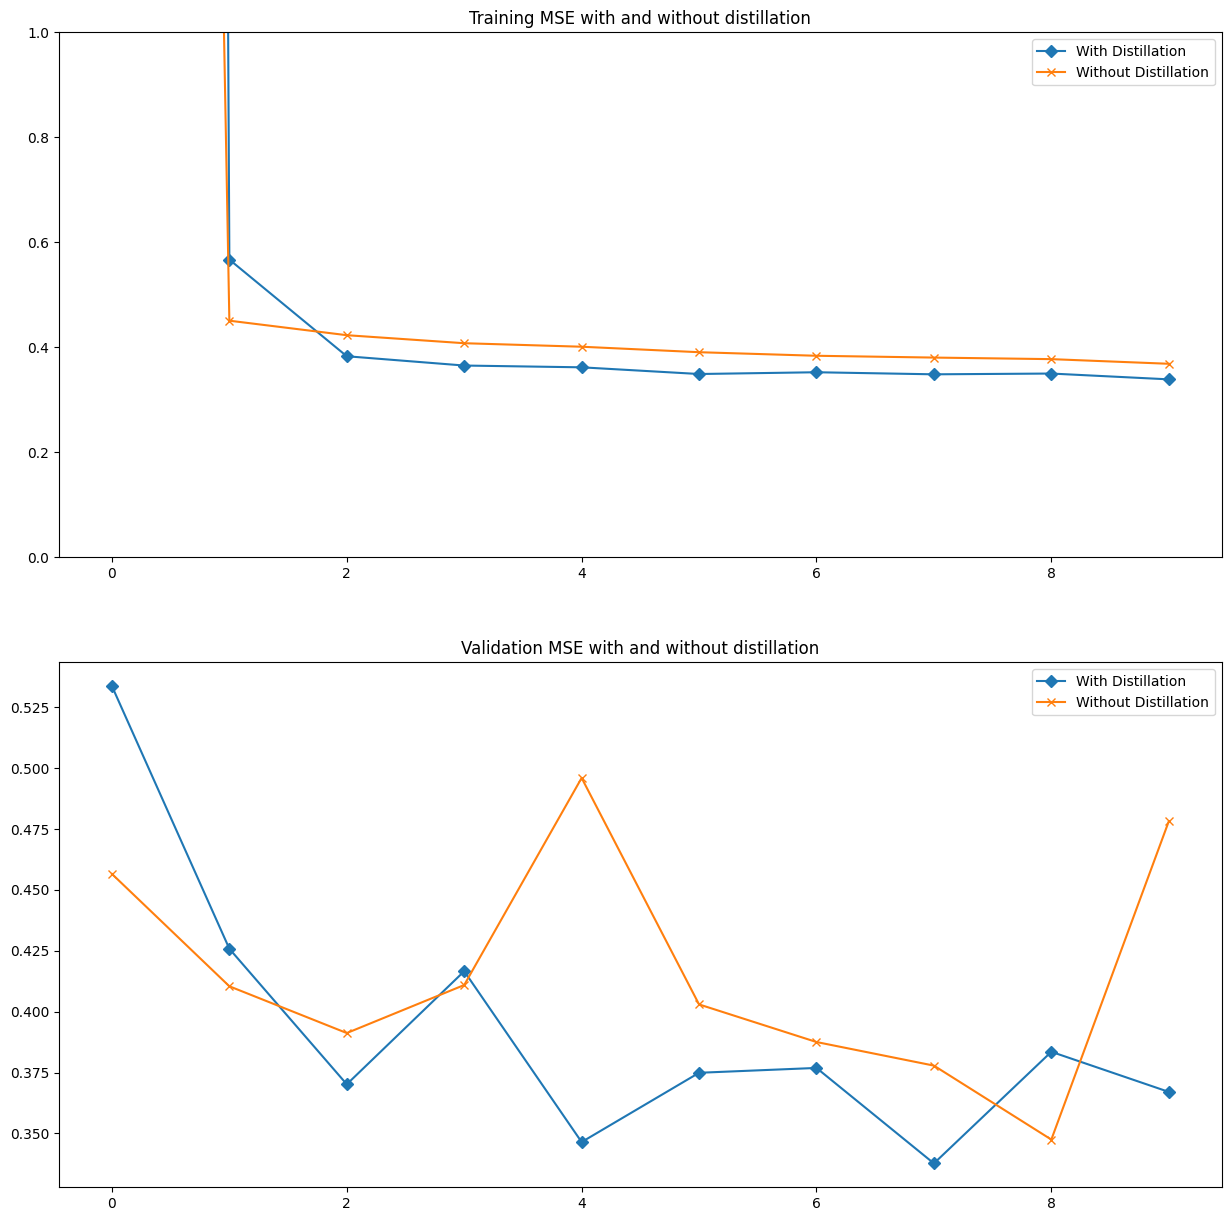

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.506 +- 0.173
Validation mse without disstillation 0.4991 +- 0.0309


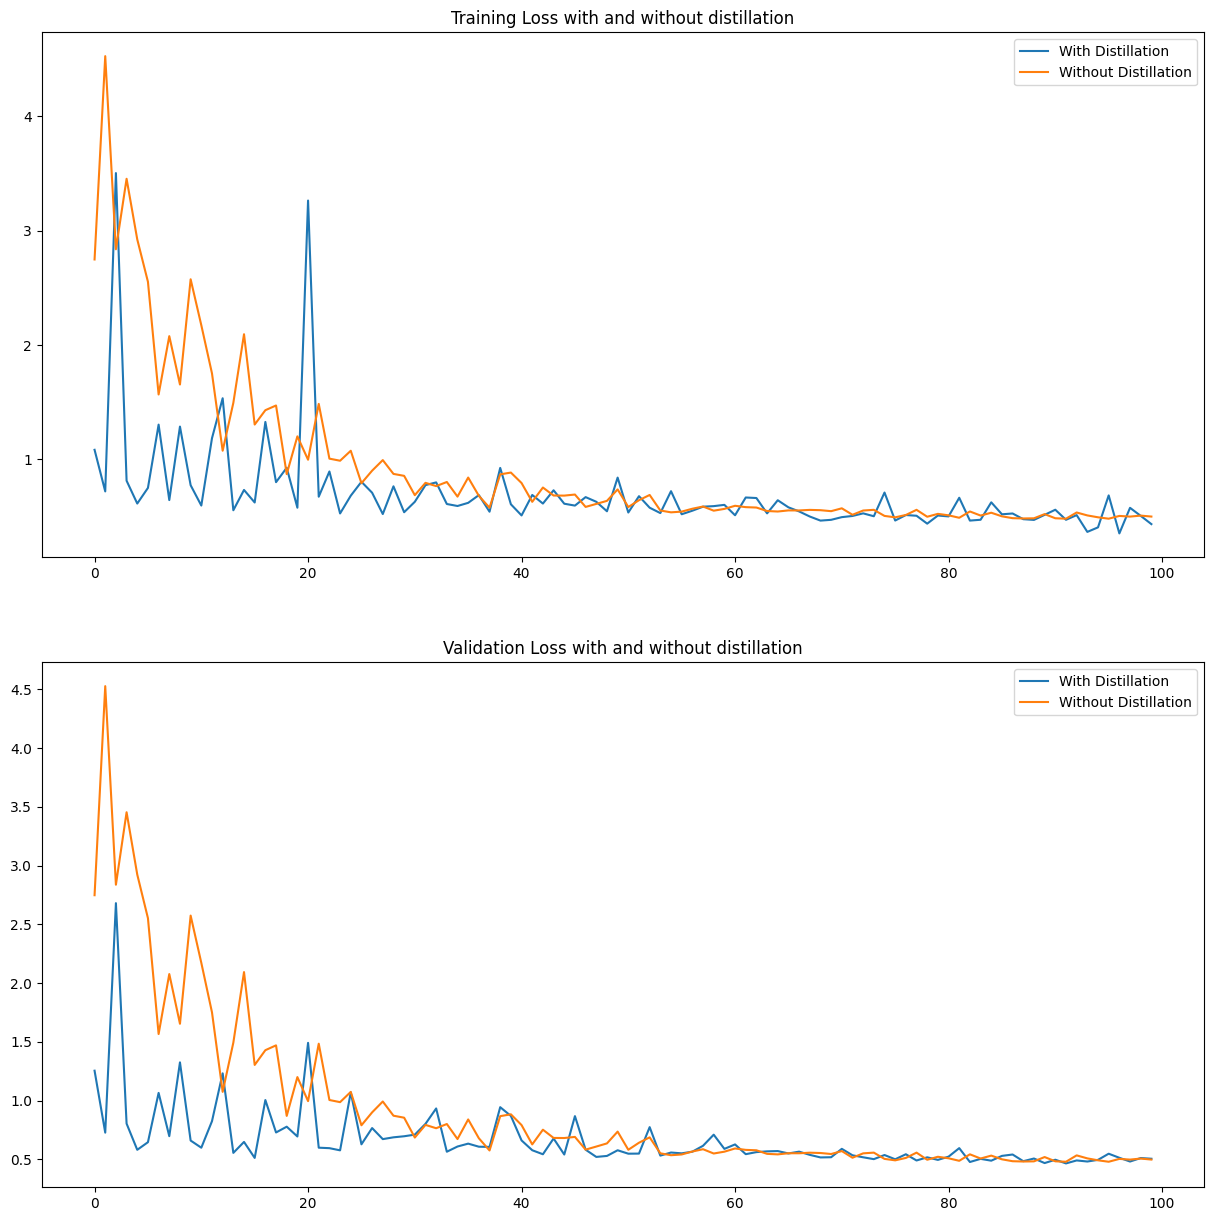

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [10]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 34.5689 - mae: 2.0952 - mape: 138.4354 - student_loss: 2.0899 - distillation_loss: 34.0052
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 26.2222 - mae: 1.9797 - mape: 130.9751 - student_loss: 1.9748 - distillation_loss: 25.6442
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 1.4358 - mae: 0.8030 - mape: 53.9280 - student_loss: 0.8101 - distillation_loss: 1.0363
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 23.3509 - mae: 1.8843 - mape: 125.0760 - student_loss: 1.8799 - distillation_loss: 22.8597
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 1.1370 - mae: 0.7413 - mape: 49.5670 - student_loss: 0.7401 - distillation_loss: 0.7078
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 1.0435 - mae: 0.6988 - mape: 46.1319 - student_loss: 0.6989 - distillation_loss: 0.6227
Epoch 7/100
492/492

492/492 [==============================] - 1s 2ms/step - mse: 0.5111 - mae: 0.5402 - mape: 35.0682 - student_loss: 0.5402 - distillation_loss: 0.1009
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5069 - mae: 0.5402 - mape: 35.7136 - student_loss: 0.5396 - distillation_loss: 0.0897
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.4761 - mae: 0.5223 - mape: 33.9109 - student_loss: 0.5224 - distillation_loss: 0.0668
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5346 - mae: 0.5456 - mape: 35.6764 - student_loss: 0.5468 - distillation_loss: 0.1207
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.4673 - mae: 0.5190 - mape: 33.9807 - student_loss: 0.5188 - distillation_loss: 0.0585
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.4479 - mae: 0.5045 - mape: 32.5584 - student_loss: 0.5045 - distillation_loss: 0.0429
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 4.6135 - mse: 432.8280 - mae: 4.6135 - mape: 306.7202
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 1.7823 - mse: 8.0002 - mae: 1.7823 - mape: 118.1877
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 1.8422 - mse: 8.3137 - mae: 1.8422 - mape: 122.4738
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 1.3517 - mse: 4.0811 - mae: 1.3517 - mape: 89.1352
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 1.4569 - mse: 4.5681 - mae: 1.4569 - mape: 96.2199
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 1.2631 - mse: 4.0046 - mae: 1.2631 - mape: 82.8947
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 1.0525 - mse: 2.3529 - mae: 1.0525 - mape: 67.8572
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 1.1320 - mse: 2.7667 - mae: 1.1320 - mape: 73.8122

492/492 [==============================] - 1s 2ms/step - loss: 0.4975 - mse: 0.4526 - mae: 0.4975 - mape: 30.1539
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4948 - mse: 0.4447 - mae: 0.4948 - mape: 30.0390
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4939 - mse: 0.4449 - mae: 0.4939 - mape: 30.1400
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4939 - mse: 0.4414 - mae: 0.4939 - mape: 30.1770
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4953 - mse: 0.4468 - mae: 0.4953 - mape: 30.1578
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4894 - mse: 0.4387 - mae: 0.4894 - mape: 29.7132
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4916 - mse: 0.4416 - mae: 0.4916 - mape: 29.6880
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5023 - mse: 0.4594 - mae: 0.5023 - mape: 30.70

In [11]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.540638267993927, 'mae': 0.5350303053855896, 'mape': 32.779598236083984, 'student_loss': 0.5325112342834473}
Test mse without disstillation {'loss': 0.5154225826263428, 'mse': 0.5141555666923523, 'mae': 0.5154225826263428, 'mape': 30.985132217407227}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
